# Testing MCTS with Various Models
Here we will test MCTS first with the DKT model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import six
import dynamics_model_class as dmc
import mcts_tests as mc
import mcts
import model_training as mtrain
import numpy as np
import scipy as sp
from matplotlib.pyplot import *
import dataset_utils
import tensorflow as tf
import tflearn
import time
import copy

from concept_dependency_graph import ConceptDependencyGraph
import data_generator as dg
from student import *
import simple_mdp as sm

In [3]:
n_concepts = 4
use_student2 = True
transition_after = True
student2_str = ('2' if use_student2 else '') + ('a' if use_student2 and transition_after else '')
learn_prob = 0.5
lp_str = '-lp{}'.format(int(learn_prob*100)) if not use_student2 else ''
n_students = 100000
seqlen = 5
filter_mastery = False
filter_str = '' if not filter_mastery else '-filtered'
policy = 'random'
epsilon = 0.3
epsilon_str = '{:.2f}'.format(epsilon) if policy == 'egreedy' else ''
filename = 'test{}-w{}-n{}-l{}{}-{}{}{}.pickle'.format(student2_str, n_concepts, n_students, seqlen,
                                                    lp_str, policy, epsilon_str, filter_str)
#concept_tree = sm.create_custom_dependency()
concept_tree = ConceptDependencyGraph()
concept_tree.init_default_tree(n_concepts)
if not use_student2:
    test_student = Student(n=n_concepts,p_trans_satisfied=learn_prob, p_trans_not_satisfied=0.0, p_get_ex_correct_if_concepts_learned=1.0)
else:
    test_student = Student2(n_concepts, transition_after=transition_after)
six.print_(filename)

test2a-w4-n100000-l5-random.pickle


In [4]:
# Generates the data
# Only run this cell if need to generate new data, otherwise skip this
if False:
    print ("Initializing synthetic data sets...")
    dg.generate_data(concept_tree, student=test_student, n_students=n_students, filter_mastery=filter_mastery, seqlen=seqlen, policy=policy, epsilon=epsilon, filename="{}{}".format(dg.SYN_DATA_DIR, filename))
    print ("Data generation completed. ")

In [5]:
# load toy data
data = dataset_utils.load_data(filename='{}{}'.format(dg.SYN_DATA_DIR, filename))

In [6]:
print('Average posttest: {}'.format(sm.expected_reward(data)))
print('Average sparse reward: {}'.format(sm.expected_sparse_reward(data)))
print('Percent of full posttest score: {}'.format(sm.percent_complete(data)))
print('Percent of all seen: {}'.format(sm.percent_all_seen(data)))
for t in data[0]:
    six.print_(t)

Average posttest: 0.4380675
Average sparse reward: 0.0
Percent of full posttest score: 0.0
Percent of all seen: 0.38158
(array([0, 0, 1, 0]), False, array([ 1.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 0, 0, 0]))
(array([0, 0, 0, 1]), False, array([ 1.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 0, 1, 0]))
(array([0, 1, 0, 0]), False, array([ 1.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 0, 1, 0]))
(array([1, 0, 0, 0]), True, array([ 1.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 1, 1, 0]))
(array([0, 0, 1, 0]), False, array([ 1.,  0.,  1.,  0.]), array([1, 0, 0, 0, 1, 1, 1, 0]))


In [7]:
input_data_, output_mask_, target_data_ = dataset_utils.preprocess_data_for_rnn(data)

six.print_(input_data_.shape)
six.print_(output_mask_.shape)
six.print_(target_data_.shape)
six.print_(output_mask_[0,:,:])
six.print_(target_data_[0,:,:])

(100000, 4, 8)
(100000, 4, 4)
(100000, 4, 4)
[[ 0.  0.  0.  1.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]]
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


In [16]:
# test_model hidden=16
# test_model_mid hidden=10
# test_model_small hidden=5
# test_model_tiny hidden=3
model_id = "test2_modelgrusimple_mid"
dmodel = dmc.DynamicsModel(model_id=model_id, timesteps=seqlen-1, dropout=1.0, load_checkpoint=False)
#dmodel2 = dmc.DynamicsModel(model_id=model_id, timesteps=seqlen-1, dropout=1.0, load_checkpoint=False)

In [17]:
# extract out the training states
class ExtractCallback(tflearn.callbacks.Callback):
    def __init__(self):
        self.tstates = []
    def on_epoch_begin(self,ts):
        self.tstates.append([])
    def on_batch_end(self,ts,snapshot):
        self.tstates[-1].append(copy.copy(ts))
ecall = ExtractCallback()

In [18]:
num_epoch_batch = 1
num_epoch_per_batch = 60
for eb in six.moves.range(num_epoch_batch):
    # add noise to each batch
    processed_input_data = input_data_ + 0.00*np.random.randn(*input_data_.shape)
    train_data = (processed_input_data[:,:,:], output_mask_[:,:,:], target_data_[:,:,:])
    dmodel.train(train_data,
                 n_epoch=num_epoch_per_batch,
                 callbacks=ecall,
                 load_checkpoint=False,
                 shuffle=True,
                 validation_set=0.1,
                 batch_size=None)
    #dmodel2.train(train_data,
    #             n_epoch=num_epoch_per_batch,
    #             callbacks=ecall,
    #             load_checkpoint=False,
    #             shuffle=True,
    #             validation_set=0.1,
    #            batch_size=None)

Training Step: 84419  | total loss: 0.00000 | time: 5.335s
| Adam | epoch: 060 | loss: 0.00000 -- iter: 89984/90000
Training Step: 84420  | total loss: 0.00000 | time: 6.484s
| Adam | epoch: 060 | loss: 0.00000 | val_loss: 0.00000 -- iter: 90000/90000
--


Train Loss Limit: 0.00000833
Val Loss Limit: 0.00000000 Thresh: 0.00000100


(0, 0.0002)

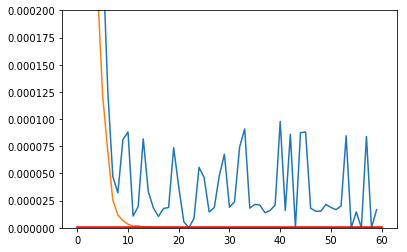

In [20]:
# binary crossentropy doesn't work
train_loss = np.array([np.mean([ts.global_loss for ts in batch]) for batch in ecall.tstates])
val_loss = np.array([batch[-1].val_loss if batch[-1].val_loss is not None else 0.0 for batch in ecall.tstates])
figure()
plot(train_loss)
plot(val_loss)
last_val_loss = np.mean(val_loss[-2:])
val_loss_thres = last_val_loss + 0.000001
last_train_loss = np.mean(train_loss[-2:])
#xlim(40,50)
six.print_('Train Loss Limit: {:.8f}'.format(last_train_loss))
six.print_('Val Loss Limit: {:.8f} Thresh: {:.8f}'.format(last_val_loss, val_loss_thres))
plot([0,train_loss.shape[0]], [last_val_loss,last_val_loss], color='#ff0000')
plot([0,train_loss.shape[0]], [val_loss_thres,val_loss_thres], color='#ff0000')
#ylim(last_val_loss - 0.00001, last_val_loss + 0.00002)
ylim(0,0.0002)

In [26]:
# predict a bit
dataix = 4
test_input_data = input_data_[dataix:dataix+1,:,:]
six.print_(test_input_data)
six.print_(data[dataix][-1])
prediction = dmodel.predict(test_input_data)
six.print_(prediction)
# add one observation of each type and see what the predictions are
for nexta in six.moves.range(n_concepts*2):
    obvec = np.zeros((n_concepts*2,))
    obvec[nexta] = 1.0
    #six.print_(test_input_data[0,:,:].shape)
    #six.print_(obvec[np.newaxis,:].shape)
    test_input_data2 = np.vstack((test_input_data[0,:,:],obvec[np.newaxis,:]))
    six.print_('Next observation: {}'.format(obvec))
    prediction = dmodel.predict(test_input_data2[np.newaxis,:,:])
    #prediction2 = dmodel2.predict(test_input_data2[np.newaxis,:,:])
    six.print_('Next prediction: ' + ' '.join('{:.4f}'.format(x) for x in prediction[0,seqlen-2,:]))
    #six.print_('Next prediction2: ' + ' '.join('{:.4f}'.format(x) for x in prediction2[0,seqlen-2,:]))

[[[ 0.  0.  0.  0.  0.  1.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.]]]
(array([0, 0, 1, 0]), False, array([ 1.,  0.,  0.,  0.]), array([1, 0, 0, 0, 1, 1, 0, 0]))
[[[  9.98491168e-01   1.61381550e-02   2.17851615e-04   2.35260511e-03]
  [  9.99761403e-01   5.73825277e-03   2.91675442e-05   4.18961397e-04]
  [  9.99817669e-01   5.21324109e-03   2.40461322e-05   3.26802605e-04]
  [  9.99827504e-01   4.97569283e-03   2.36431988e-05   3.09593190e-04]]]
Next observation: [ 1.  0.  0.  0.  0.  0.  0.  0.]
Next prediction: 0.9998 0.0050 0.0000 0.0003
Next observation: [ 0.  1.  0.  0.  0.  0.  0.  0.]
Next prediction: 0.9998 0.0050 0.0000 0.0003
Next observation: [ 0.  0.  1.  0.  0.  0.  0.  0.]
Next prediction: 0.9998 0.0050 0.0000 0.0003
Next observation: [ 0.  0.  0.  1.  0.  0.  0.  0.]
Next prediction: 0.9998 0.0050 0.0000 0.0003
Next observation: [ 0.  0.  0.  0.  1.  0.  0.  0.]
Next prediction: 0.9998 0.0050 0.

In [7]:
# save the model to a checkpoint file
chkpt = 'tempmodel'
#dmodel.save(chkpt)

#chkpt2 = 'tempmodel2'
#dmodel2.save(chkpt2)

In [30]:
# test the model on the real environment
test_horizon = 6
n_rollouts = 3000
n_trajectories = 24
r_type = mcts.SPARSE

test_student = Student2(n_concepts, transition_after=transition_after)
test_student.reset()
test_student.knowledge[0] = 1 # initialize the first concept to be known
sim = StudentExactSim(test_student.copy(), concept_tree)

starttime = time.time()
acc, bestq = mc.test_dkt_chunk(n_trajectories, concept_tree, sim, model_id, [chkpt], test_horizon, n_rollouts, r_type)
#mc.test_dkt(model_id, n_concepts, transition_after, test_horizon, n_rollouts, n_trajectories, r_type, True, chkpt=chkpt)
endtime = time.time()
six.print_('Time Elapsed {}'.format(endtime - starttime))
six.print_('Acc: {} Best Q: {}'.format(acc, bestq))

INFO:tensorflow:Restoring parameters from /usr0/home/zguo/Documents/smart-tutor/code/tempmodel
Time Elapsed 139.59412813186646
Acc: 0.0 Best Q: 0.47858624160289776


In [13]:
# test memoization
starttime = time.time()
mtrain.dkt_memoize_single(n_concepts, model_id, chkpt, 3, 'mem_tempmodel')
endtime = time.time()
six.print_('Time Elapsed {}'.format(endtime - starttime))

INFO:tensorflow:Restoring parameters from /usr0/home/zguo/Documents/smart-tutor/code/tempmodel
Time Elapsed 2.7049694061279297


In [11]:
# see memoization
memdata = np.load('mem_tempmodel.npz')
six.print_(memdata.files)
six.print_(memdata['mem_arrays'].shape)
six.print_(memdata['mem_arrays'][0])
six.print_(memdata['mem_arrays'][1])

['mem_arrays']
(4,)
[[ 0.  0.  0.  0.]]
[[  9.67990458e-01   1.84817687e-02   1.44554321e-02   3.60819027e-02]
 [  9.98491168e-01   1.61381550e-02   2.17851615e-04   2.35260511e-03]
 [  9.98841822e-01   6.13134936e-04   1.02831842e-02   1.30330515e-03]
 [  9.96319532e-01   1.32317375e-03   4.43759171e-04   4.45438549e-03]
 [  9.97196317e-01   1.39679399e-03   4.15361894e-04   3.48358159e-03]
 [  9.66320395e-01   5.01056090e-02   1.91735718e-02   3.67798619e-02]
 [  9.72327530e-01   2.05066483e-02   3.94504704e-02   2.91881897e-02]
 [  9.59235430e-01   1.81578547e-02   1.50675327e-02   4.35173400e-02]]
